In [ ]:
import random
import torch
import numpy as np

# for easier reading np
np.set_printoptions(precision=3,suppress=True)

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
X = torch.tensor(iris.data[:, :3], dtype=torch.float32)  # we only take the first three features.
y = torch.tensor(iris.data[:, 3], dtype=torch.float32)   # we use the fourth feature as the target.

# Uncomment this line for problem 2 (logistic regression)
# X = torch.tensor(iris.data, dtype=torch.float32)
# y = torch.tensor(iris.target == 2, dtype=torch.float32)

In [ ]:
# Partition the data into Training and Testing (80:20 split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=0)

print('X_train', X_train.shape)
print('X_test', X_test.shape)

X_train torch.Size([120, 3])
X_test torch.Size([30, 3])


In [ ]:
# Reading the dataset
def data_iter(batch_size, features, labels):
    num_examples = len(features)

    # The examples are read at random, in no particular order
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = indices[i:i + batch_size]
        yield features[j], labels[j]

# Check data reader
for X_batch, y_batch in data_iter(batch_size=10, features=X_train, labels=y_train):
    print('X_batch', X_batch.shape, X_batch[0])
    print('y_batch', y_batch.shape, y_batch[0])
    break

X_batch torch.Size([10, 3]) tensor([5.2000, 3.4000, 1.4000])
y_batch torch.Size([10]) tensor(0.2000)


In [ ]:
# Initializing Model Parameters
w = torch.nn.Parameter(data=torch.zeros((3, 1)), requires_grad=True)
torch.nn.init.normal_(w, mean=0, std=0.01)
b = torch.nn.Parameter(data=torch.zeros((1, 1)), requires_grad=True)
print('w', w)
print('b', b)

w Parameter containing:
tensor([[ 0.0030],
        [-0.0046],
        [ 0.0054]], requires_grad=True)
b Parameter containing:
tensor([[0.]], requires_grad=True)


In [ ]:
# Defining the Model
def linreg(X, w, b):
    """The linear regression model."""
    return X@w + b

# Check model
for X_batch, y_batch in data_iter(batch_size=10, features=X_train, labels=y_train):
    out_batch = linreg(X_batch, w, b)
    print('X_batch', X_batch.shape, X_batch[0])
    print('out_batch', out_batch.shape, out_batch[0])
    break

X_batch torch.Size([10, 3]) tensor([5.8000, 2.7000, 3.9000])
out_batch torch.Size([10, 1]) tensor([0.0261], grad_fn=<SelectBackward0>)


In [ ]:
# Defining the Loss Function
def squared_loss(y_hat, y):
    """Squared loss."""
    return torch.mean((y_hat - y.view(y_hat.shape))**2 / 2)

# Check loss
err = squared_loss(torch.tensor([1, 2, 3]), torch.tensor([3, 2, 1]))
print('err =', err)

err = tensor(1.3333)


In [ ]:
# Defining the Optimization Algorithm
def sgd(params, grads, lr):
    """Minibatch stochastic gradient descent."""
    for p, g in zip(params, grads):
        p.data -= lr * g

**Training**

In [ ]:
lr = 0.01
batch_size = 10
num_epochs = 50
net = linreg
loss = squared_loss

epoch 000, test loss 0.91037, Rsquare -2.792
epoch 001, test loss 0.05594, Rsquare 0.767
epoch 002, test loss 0.07022, Rsquare 0.707
epoch 003, test loss 0.03867, Rsquare 0.839
epoch 004, test loss 0.15591, Rsquare 0.350
epoch 005, test loss 0.10444, Rsquare 0.565
epoch 006, test loss 0.03282, Rsquare 0.863
epoch 007, test loss 0.04392, Rsquare 0.817
epoch 008, test loss 0.03525, Rsquare 0.853
epoch 009, test loss 0.03328, Rsquare 0.861
epoch 010, test loss 0.06707, Rsquare 0.721
epoch 011, test loss 0.07221, Rsquare 0.699
epoch 012, test loss 0.04070, Rsquare 0.830
epoch 013, test loss 0.03291, Rsquare 0.863
epoch 014, test loss 0.02973, Rsquare 0.876
epoch 015, test loss 0.03170, Rsquare 0.868
epoch 016, test loss 0.03640, Rsquare 0.848
epoch 017, test loss 0.11561, Rsquare 0.518
epoch 018, test loss 0.05143, Rsquare 0.786
epoch 019, test loss 0.03962, Rsquare 0.835
epoch 020, test loss 0.04624, Rsquare 0.807
epoch 021, test loss 0.07803, Rsquare 0.675
epoch 022, test loss 0.03203, R

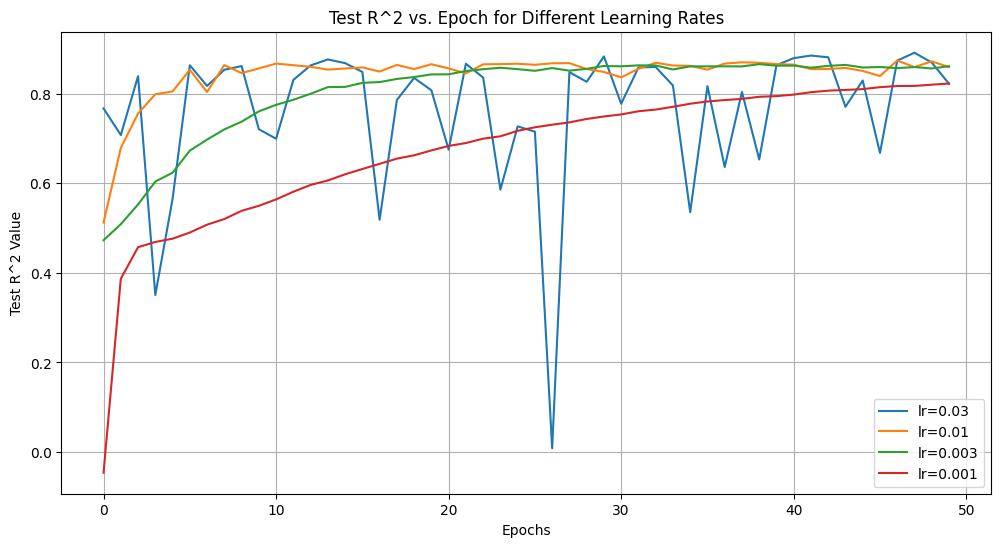

In [ ]:
import torch
import matplotlib.pyplot as plt

# Define a list of learning rates to experiment with
learning_rates = [0.03, 0.01, 0.003, 0.001]

# Create a dictionary to store test R^2 values for each learning rate
test_r_squared_dict = {}

for lr in learning_rates:
    # Initialize the parameters of the model
    torch.nn.init.normal_(w, mean=0, std=0.01)
    torch.nn.init.zeros_(b)

    # Create empty lists to store test R^2 values for each epoch
    test_r_squared = []
    train_r_squared = []

    for epoch in range(num_epochs):
        # Evaluate model
        with torch.no_grad():
            yhat = net(X_test, w, b)[:, 0]
            mse = torch.sum((y_test - yhat)**2)
            var = torch.sum((y_test - torch.mean(y_test))**2)
            R_sq = 1 - mse / var
            test_l = loss(yhat, y_test)
            print(f'epoch {epoch:03d}, test loss {float(test_l):.5f}, Rsquare {R_sq:.3f}')

        # Train for one epoch
        for X_batch, y_batch in data_iter(batch_size=10, features=X_train, labels=y_train):
            # Use model to compute predictions
            yhat = net(X_batch, w, b)
            l = loss(yhat, y_batch)  # Minibatch loss in `X_batch` and `y_batch`

            # Compute gradients by back propagation
            l.backward()

            # Update parameters using their gradient
            sgd([w, b], [w.grad, b.grad], lr)

            # Reset gradients
            w.grad = b.grad = None

        with torch.no_grad():
            yhat_train = net(X_train, w, b)[:, 0]
            mse_train = torch.sum((y_train - yhat_train)**2)
            var_train = torch.sum((y_train - torch.mean(y_train))**2)
            train_r_sq = 1 - mse_train / var_train
            train_r_squared.append(train_r_sq.item())  # Append the R^2 value to the list

        # Compute testing R^2 at the end of the epoch
        with torch.no_grad():
            yhat_test = net(X_test, w, b)[:, 0]
            mse_test = torch.sum((y_test - yhat_test)**2)
            var_test = torch.sum((y_test - torch.mean(y_test))**2)
            test_r_sq = 1 - mse_test / var_test
            test_r_squared.append(test_r_sq.item())  # Append the R^2 value to the list

    # Store the test R^2 values for the current learning rate in the dictionary
    test_r_squared_dict[lr] = test_r_squared

# Plot test R^2 vs. epoch for each learning rate
plt.figure(figsize=(12, 6))
for lr in learning_rates:
    plt.plot(range(num_epochs), test_r_squared_dict[lr], label=f'lr={lr}')

plt.xlabel('Epochs')
plt.ylabel('Test R^2 Value')
plt.legend()
plt.title('Test R^2 vs. Epoch for Different Learning Rates')
plt.grid(True)
plt.show()


epoch 000, test loss 0.74077, Rsquare -2.086
epoch 001, test loss 0.23767, Rsquare 0.010
epoch 002, test loss 0.14111, Rsquare 0.412
epoch 003, test loss 0.12707, Rsquare 0.471
epoch 004, test loss 0.12465, Rsquare 0.481
epoch 005, test loss 0.12264, Rsquare 0.489
epoch 006, test loss 0.11981, Rsquare 0.501
epoch 007, test loss 0.11644, Rsquare 0.515
epoch 008, test loss 0.11242, Rsquare 0.532
epoch 009, test loss 0.10858, Rsquare 0.548
epoch 010, test loss 0.10646, Rsquare 0.556
epoch 011, test loss 0.10241, Rsquare 0.573
epoch 012, test loss 0.09908, Rsquare 0.587
epoch 013, test loss 0.09576, Rsquare 0.601
epoch 014, test loss 0.09277, Rsquare 0.614
epoch 015, test loss 0.08957, Rsquare 0.627
epoch 016, test loss 0.08710, Rsquare 0.637
epoch 017, test loss 0.08426, Rsquare 0.649
epoch 018, test loss 0.08106, Rsquare 0.662
epoch 019, test loss 0.07919, Rsquare 0.670
epoch 020, test loss 0.07743, Rsquare 0.677
epoch 021, test loss 0.07543, Rsquare 0.686
epoch 022, test loss 0.07311, R

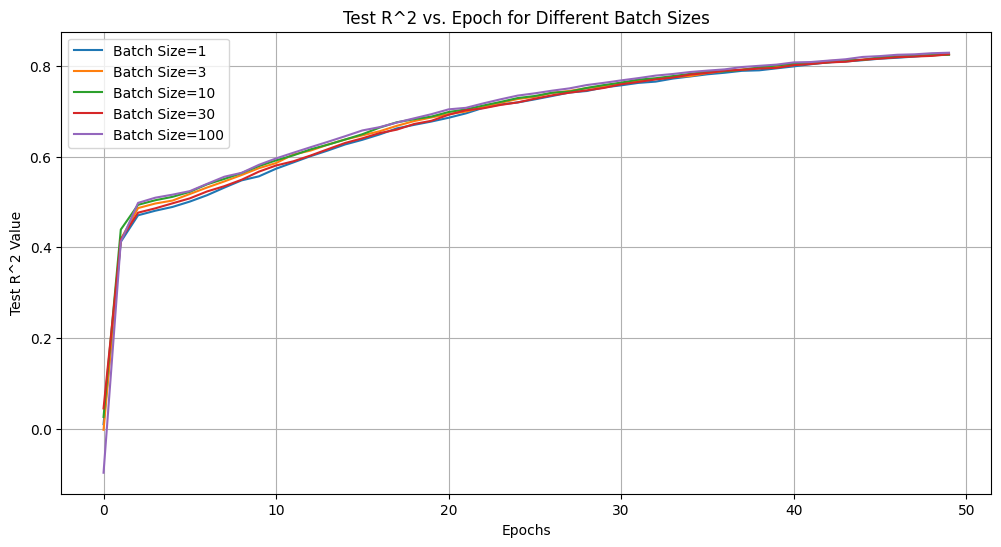

In [ ]:
import torch
import matplotlib.pyplot as plt

# Define a list of batch sizes to experiment with
batch_sizes = [1, 3, 10, 30, 100]

# Create a dictionary to store test R^2 values for each batch size
test_r_squared_dict = {}

for batch_size in batch_sizes:
    # Initialize the parameters of the model
    torch.nn.init.normal_(w, mean=0, std=0.01)
    torch.nn.init.zeros_(b)

    # Create empty lists to store test R^2 values for each epoch
    test_r_squared = []
    train_r_squared

    for epoch in range(num_epochs):
        # Evaluate model
        with torch.no_grad():
            yhat = net(X_test, w, b)[:, 0]
            mse = torch.sum((y_test - yhat)**2)
            var = torch.sum((y_test - torch.mean(y_test))**2)
            R_sq = 1 - mse / var
            test_l = loss(yhat, y_test)
            print(f'epoch {epoch:03d}, test loss {float(test_l):.5f}, Rsquare {R_sq:.3f}')

        # Train for one epoch
        for X_batch, y_batch in data_iter(batch_size=10, features=X_train, labels=y_train):
            # Use model to compute predictions
            yhat = net(X_batch, w, b)
            l = loss(yhat, y_batch)  # Minibatch loss in `X_batch` and `y_batch`

            # Compute gradients by back propagation
            l.backward()

            # Update parameters using their gradient
            sgd([w, b], [w.grad, b.grad], lr)

            # Reset gradients
            w.grad = b.grad = None

        with torch.no_grad():
            yhat_train = net(X_train, w, b)[:, 0]
            mse_train = torch.sum((y_train - yhat_train)**2)
            var_train = torch.sum((y_train - torch.mean(y_train))**2)
            train_r_sq = 1 - mse_train / var_train
            train_r_squared.append(train_r_sq.item())  # Append the R^2 value to the list

        # Compute testing R^2 at the end of the epoch
        with torch.no_grad():
            yhat_test = net(X_test, w, b)[:, 0]
            mse_test = torch.sum((y_test - yhat_test)**2)
            var_test = torch.sum((y_test - torch.mean(y_test))**2)
            test_r_sq = 1 - mse_test / var_test
            test_r_squared.append(test_r_sq.item())  # Append the R^2 value to the list

    # Store the test R^2 values for the current batch size in the dictionary
    test_r_squared_dict[batch_size] = test_r_squared

# Plot test R^2 vs. epoch for each batch size
plt.figure(figsize=(12, 6))
for batch_size in batch_sizes:
    plt.plot(range(num_epochs), test_r_squared_dict[batch_size], label=f'Batch Size={batch_size}')

plt.xlabel('Epochs')
plt.ylabel('Test R^2 Value')
plt.legend()
plt.title('Test R^2 vs. Epoch for Different Batch Sizes')
plt.grid(True)
plt.show()

In [ ]:
# R2 = 1 - MSE/var(y)
print('Intercept = ', b.detach().numpy())
print('Coefficients = \n', w.detach().numpy())

with torch.no_grad():
    yhat = net(X_train, w, b)[:, 0]
    mse = torch.sum((y_train - yhat)**2)
    var = torch.sum((y_train - torch.mean(y_train))**2)
    R_sq_train = 1 - mse / var

    yhat = net(X_test, w, b)[:, 0]
    mse = torch.sum((y_test - yhat)**2)
    var = torch.sum((y_test - torch.mean(y_test))**2)
    R_sq_test = 1 - mse / var

print('Train R square = ', format(R_sq_train.numpy(),".3f"))
print('Test R square = ', format(R_sq_test.numpy(),".3f"))

NameError: ignored